<a href="https://colab.research.google.com/github/Dev-ika/Abusive-Behavior-Classification/blob/main/Binary_relevance_and_classifier_chains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

## Load training and test data

In [ ]:
train_df = pd.read_csv('../inputs/train.csv')
test_df = pd.read_csv('../inputs/Realtimedatabasetest.csv')

## Examine the data (EDA)

In [ ]:
train_df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
76688,cd624c6112976613,"As I have declared earlier, I have no interest...",0,0,0,0,0,0
30328,50843e0ffc5bfe37,This is a consequence of the fact that the art...,0,0,0,0,0,0
146427,2bf678447938f07f,"""\n\nWarning: Editing Aguri (caste) - Gross vi...",0,0,0,0,0,0
38885,67c342f9ff8c9e3a,Reverting a link with spam is a double standar...,1,0,0,0,0,0
152372,8c478b1db65f720e,"""\n\nNASTRO\nHelo Headbomb, I am somewhat conc...",0,0,0,0,0,0


In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [ ]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [ ]:
# check missing values in numeric columns
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There are no missing numeric values. Based on the mean values, it also looks like there are many comments which are not labelled in any of the six categories.

In [ ]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [ ]:
test_df.head()

,id,name,comment_text
0,5988,Devika Anil,hello
1,8517,Devika Anil,IMAGE
2,9563,Devika Anil,you are a faggot
3,307,Devika Anil,I'm going to kill you in your sleep
4,6712,Devika Anil,Fuck you


In [ ]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment

,id,name,comment_text


All rows in the training and test data contain comments, so there's no need to clean up null fields.

In [ ]:
# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 12
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


As mentioned earlier, majority of the comments in the training data are not labelled in one or more of these categories.

In [ ]:
# Let's look at the character length for the rows in the training data and record these
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))

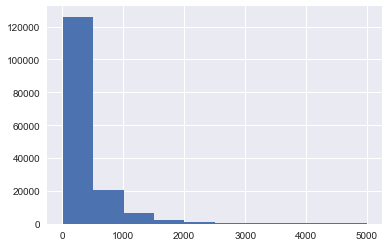

In [ ]:
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

Next, let's examine the correlations among the target variables.

In [ ]:
data = train_df[cols_target]

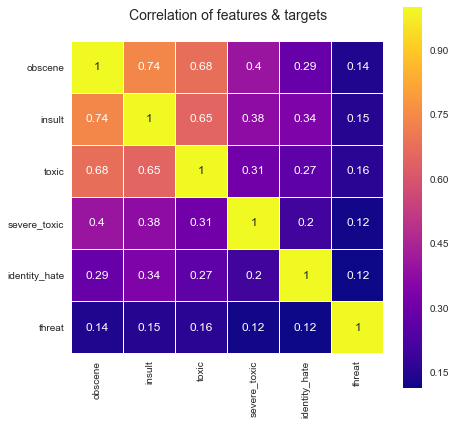

In [ ]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

What about the character length & distribution of the comment text in the test data?

In [ ]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

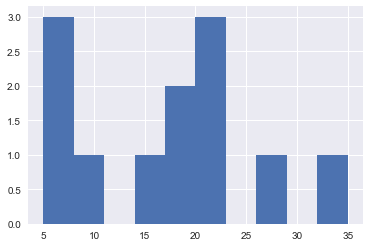

In [ ]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

Now, the shape of character length distribution looks similar between the training data and the train data. For the training data, I guess the train data were clipped to 5,000 characters to facilitate the folks who did the labelling of the comment categories.

## Clean up the comment text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [ ]:
# clean the comment_text in train_df
cleaned_train_comment = []
for i in range(0,len(train_df)):
    cleaned_comment = clean_text(train_df['comment_text'][i])
    cleaned_train_comment.append(cleaned_comment)
train_df['comment_text'] = pd.Series(cleaned_train_comment).astype(str)

In [ ]:
# clean the comment_text in test_df
cleaned_test_comment = []
for i in range(0,len(test_df)):
    cleaned_comment = clean_text(test_df['comment_text'][i])
    cleaned_test_comment.append(cleaned_comment)
test_df['comment_text'] = pd.Series(cleaned_test_comment).astype(str)


## Define X from entire train & test data for use in tokenization by Vectorizer

In [ ]:
train_df = train_df.drop('char_length',axis=1)

In [ ]:
X = train_df.comment_text
test_X = test_df.comment_text

In [ ]:
print(X.shape, test_X.shape)

(159571,) (153164,)


## Vectorize the data

In [ ]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [ ]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [ ]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

## Solving a multi-label classification problem
One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:
* _**Binary Relevance.**_ This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.
* _**Classifier Chains.**_ In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.
* _**Label Powerset.**_ This method transforms the problem into a multi-class problem  where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem. {Thanks Joshua for pointing out.}

## Binary Relevance - build a multi-label classifier using Logistic Regression

In [ ]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv('../inputs/sample_submission.csv')

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing obscene
Training accuracy is 0.9832300355327722
... Processing insult
Training accuracy is 0.9755469352200588
... Processing toxic
Training accuracy is 0.9639846839337975
... Processing severe_toxic
Training accuracy is 0.9920724943755445
... Processing identity_hate
Training accuracy is 0.9939713356436947
... Processing threat
Training accuracy is 0.9981199591404453


### Create submission file

In [ ]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999956,0.463380,0.999965,0.050203,0.971122,0.431323
1,0000247867823ef7,0.002395,0.000431,0.000401,0.000329,0.003284,0.000396
2,00013b17ad220c46,0.011101,0.000119,0.003185,0.000035,0.007277,0.001253
3,00017563c3f7919a,0.001327,0.002130,0.000965,0.000117,0.000872,0.000033
4,00017695ad8997eb,0.019301,0.000834,0.001252,0.000607,0.003282,0.000567


In [ ]:
# generate submission file
submission_binary.to_csv('../inputs/submission_binary.csv',index=False)

#### Binary Relevance with Logistic Regression classifier scored 0.074 on the public leaderboard.

## Classifier Chains - build a multi-label classifier using Logistic Regression

In [ ]:
# create submission file
submission_chains = pd.read_csv('../inputs/sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing obscene
Training Accuracy is 0.9832300355327722
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing insult
Training Accuracy is 0.9819202737339492
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing toxic
Training Accuracy is 0.9676068959898728
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing severe_toxic
Training Accuracy is 0.9931065168482995
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing identity_hate
Training Accuracy is 0.9955819039800465
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing threat
Training Accuracy is 0.9985774357496037
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


### Create submission file

In [ ]:
submission_chains.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999968,0.420012,0.999965,0.189226,0.900363,0.599430
1,0000247867823ef7,0.002540,0.000003,0.000401,0.000077,0.004424,0.000122
2,00013b17ad220c46,0.007937,0.000001,0.003185,0.000010,0.005202,0.000527
3,00017563c3f7919a,0.001175,0.000066,0.000965,0.000069,0.000635,0.000006
4,00017695ad8997eb,0.021178,0.000006,0.001252,0.000172,0.002019,0.000106


In [ ]:
# generate submission file
submission_chains.to_csv('../inputs/submission_chains.csv', index=False)

## Create a combined submission

In [ ]:
# create submission file
submission_combined = pd.read_csv('../inputs/sample_submission.csv')

Combine using simple average from Binary Relevance and Classifier Chains.

In [ ]:
# corr_targets = ['obscene','insult','toxic']
for label in cols_target:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])

In [ ]:
submission_combined.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999962,0.441696,0.999965,0.119715,0.935742,0.515377
1,0000247867823ef7,0.002467,0.000217,0.000401,0.000203,0.003854,0.000259
2,00013b17ad220c46,0.009519,0.000060,0.003185,0.000023,0.006240,0.000890
3,00017563c3f7919a,0.001251,0.001098,0.000965,0.000093,0.000754,0.000020
4,00017695ad8997eb,0.020240,0.000420,0.001252,0.000389,0.002650,0.000336


In [ ]:
# generate submission file
submission_combined.to_csv('../inputs/submission_combined.csv', index=False)